# Entendendo mapas de características (Feature maps).

Redes convolucionais revolucionaram o campo da visão computacional pela capacidade de performar tarefas de classificação, detecção e segmentação de imagens de maneira altamente eficiente. Um dos principais componentes de uma CNN são as camadas convolucionais, com a função de extrair características da imagem de entrada. A saída de uma camada convolucional é um conjunto de mapas de características (feature maps).

In [11]:
#Bibliotecas utilizadas para acessar as das camadas convolucionais e visualização dos mapas.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision.models as models
from torchvision import transforms
import requests
from PIL import Image as A

In [12]:
#Rede utilizada no exemplo com pesos e vieses treinados.

class CNNnet(nn.Module):
  def __init__(self, n_classes):
    super(CNNnet,self).__init__()
        
    self.feature_extractor=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
       
        nn.MaxPool2d(kernel_size=2,padding=0, dilation=1, ceil_mode=False),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,padding=0, dilation=1, ceil_mode=False),
       
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1,padding=1) ,
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,padding=0, dilation=1, ceil_mode=False))
    
    self.flatten=nn.Sequential(nn.Flatten())
    
    self.classifier=nn.Sequential(
        nn.Linear(in_features=4096, out_features=1028, bias=True),
        nn.ReLU(),

        nn.Linear(in_features=1028, out_features=512, bias=True),
        nn.BatchNorm1d(512),
        nn.ReLU(),

        nn.Linear(in_features=512, out_features=n_classes, bias=True))

  def forward(self,x):
    x=self.feature_extractor(x)
    x=self.flatten(x)
    logits=self.classifier(x)
    return logits

In [13]:
# Download da imagem
expl={'bird':"https://www.allaboutbirds.org/guide/assets/photo/297366501-480px.jpg"}
img_data = requests.get(expl['bird']).content
with open('bird.jpg', 'wb') as handler:
  handler.write(img_data)

# Conjunto de transformações aplicadas a imagem de entrada.

transfor=transforms.Compose([transforms.Resize(size=(32,32)),transforms.ToTensor(),transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

def resizer(img):
  resizer256=transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(256,256))])
  img_resized=resizer256(img)
  img_resized=img_resized.squeeze(0)
  return np.array(img_resized)


Text(0.5, 1.0, 'Imagem original')

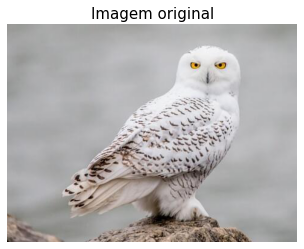

In [26]:
_img=A.open('bird.jpg')
plt.imshow(_img)
plt.axis("off")
plt.title("Imagem original",fontsize=15)

# Oque são mapas de características (Feature maps) ?

Feature maps são a saída de uma camada convolucional. Cada um deles representa a ativação de um conjunto de neurônios presentes na camada. O tamanho dos mapas de características depende de uma série de fatores como: tamanho da imagem de entrada, tamanho do kernel, valor de stride e tamanho do padding. Cada píxel no feature map expressa a ativação de um neurônio para uma região específica da imagem.

In [14]:
# Instanciando modelo e carregando pesos. 
model_=CNNnet(n_classes=10)
model_.load_state_dict(torch.load('/content/CNN_model_CIFAR10_weights_9marco'))

<All keys matched successfully>

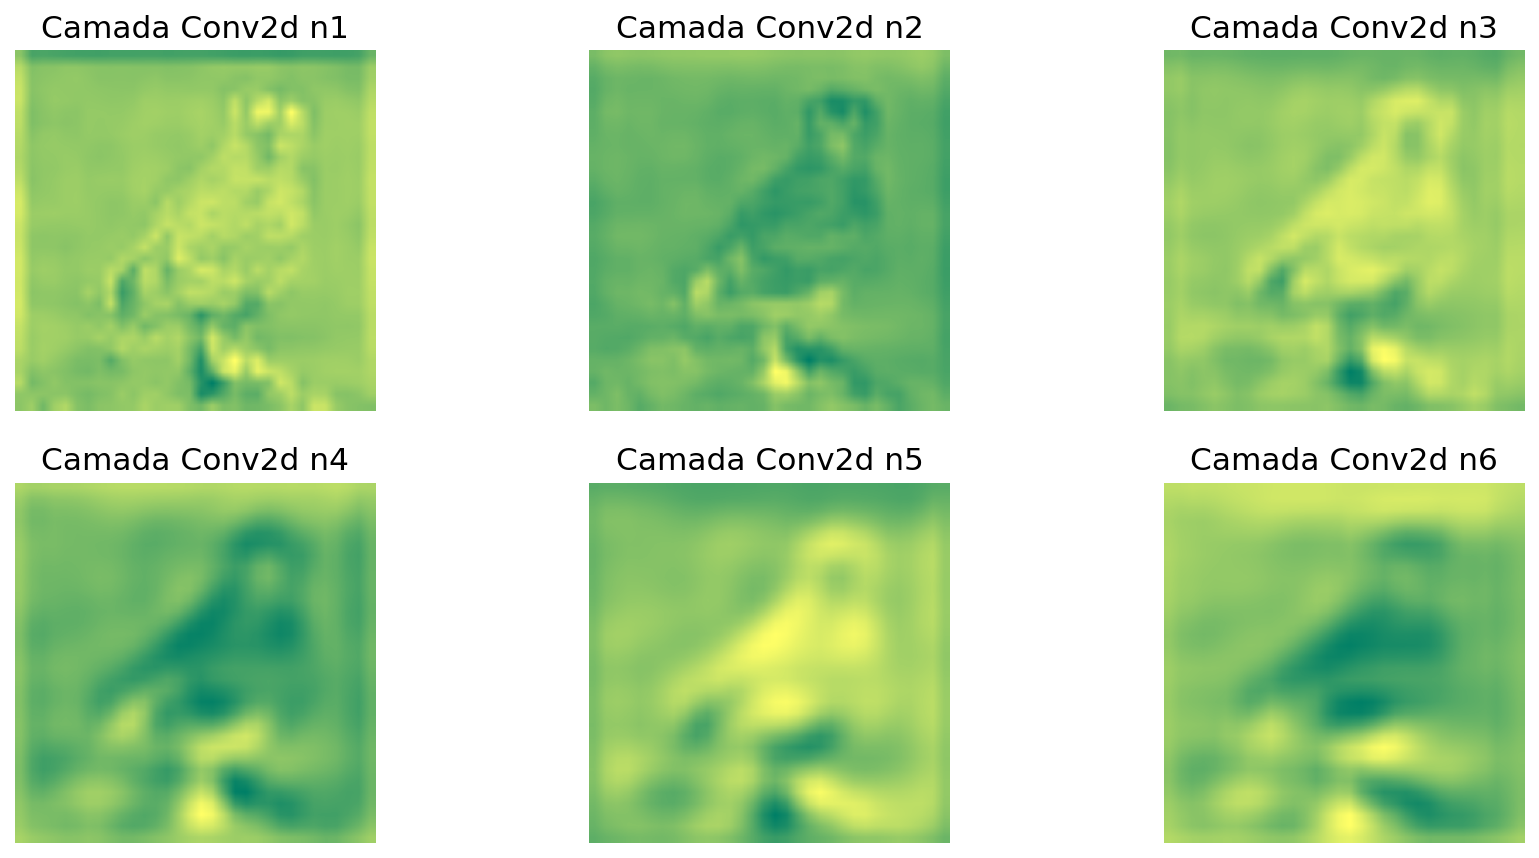

In [15]:
# Criando variáveis para armezenar imagem teste, camadas conv e mapas de características
conv_layers=[]
processed_img=[]
_img=A.open('bird.jpg')
input_img=transfor(_img)

# Extraindo camadas conv. do modelo
model_children=list(model_.children())
model_.eval()
for layer in model_children[0]:
  if type(layer) == nn.Conv2d:
    conv_layers.append(layer)

# Obtendo feature maps
for i in range(len(conv_layers)):
  img=input_img.unsqueeze(0)
  for layer_ in conv_layers[:i+1]:
    img=layer_(img)
  
  feature_map = img.detach().numpy()[0]
  gray_scale = np.sum(feature_map,0)
  gray_scale = (gray_scale / feature_map.shape[0])
  processed_img.append(resizer(gray_scale))
  # processed_img.append(gray_scale)

# Plotando resultados.
fig = plt.figure(figsize=(14,7),dpi=150)
for i in range(len(processed_img)):
    a = fig.add_subplot(2, 3, i+1)
    imgplot = plt.imshow(processed_img[i],cmap='summer')
    a.axis("off")
    a.set_title(f"Camada Conv2d n{i+1}", fontsize=15)

# Qual a importância dos mapas de características?

Como dito anteriormente, cada camada convolucional de uma CNN aprende a extrair características de uma imagem de entrada. Visualizando os features maps que são a representação intermediária da imagem de entrada é possível entender como a CNN processa a imagem em cada um dos seus estágios. Consequentemente ajudando a perceber quais são os pontos fortes e fracos do modelo e identificando áreas de melhoria.  